<a href="https://colab.research.google.com/github/gusmendesbh/project4-group2/blob/main/used_cars_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 336 kB in 4s (89.4 kB/s)
Reading package lists... Done


In [ ]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [ ]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/vehicles.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("vehicles.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [ ]:
df = car_sales_df.toPandas()


Exploratory Data Analysis (EDA)

In [ ]:
df.shape


(441802, 26)

In [ ]:
df.columns


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [ ]:
df.isna().sum()


id                   0
url               9884
region            6901
region_url        6533
price             6446
year              7890
manufacturer     28937
model            17506
condition       187143
cylinders       190798
fuel             16344
odometer         17801
title_status     21618
transmission     15932
VIN             174486
drive           144178
size            319997
type            106892
paint_color     143839
image_url        13732
description      13733
county          382283
state            23077
lat              25397
long             24715
posting_date     22477
dtype: int64

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441802 entries, 0 to 441801
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            441802 non-null  object
 1   url           431918 non-null  object
 2   region        434901 non-null  object
 3   region_url    435269 non-null  object
 4   price         435356 non-null  object
 5   year          433912 non-null  object
 6   manufacturer  412865 non-null  object
 7   model         424296 non-null  object
 8   condition     254659 non-null  object
 9   cylinders     251004 non-null  object
 10  fuel          425458 non-null  object
 11  odometer      424001 non-null  object
 12  title_status  420184 non-null  object
 13  transmission  425870 non-null  object
 14  VIN           267316 non-null  object
 15  drive         297624 non-null  object
 16  size          121805 non-null  object
 17  type          334910 non-null  object
 18  paint_color   297963 non

In [ ]:
df['posting_date'].head()

0    None
1    None
2    None
3    None
4    None
Name: posting_date, dtype: object

In [ ]:
df.drop(['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'size'], axis=1, inplace=True)


In [ ]:
df.isna().sum()/df.shape[0]*100


region           1.562012
price            1.459025
year             1.785868
manufacturer     6.549767
model            3.962408
condition       42.359021
cylinders       43.186314
fuel             3.699395
odometer         4.029180
title_status     4.893142
transmission     3.606140
drive           32.634076
type            24.194549
paint_color     32.557345
state            5.223381
posting_date     5.087573
dtype: float64

In [ ]:
df = df.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])


In [ ]:
df.fillna('unknown', inplace=True)


Handling duplicated values


In [ ]:
df.duplicated().sum()


10886

In [ ]:
df = df.drop_duplicates()


In [ ]:
df.shape


(390518, 16)

In [ ]:
manufacturer_values = df['manufacturer'].value_counts()


In [ ]:
print(manufacturer_values)


ford                                                             67827
chevrolet                                                        52023
toyota                                                           32677
honda                                                            20547
nissan                                                           18254
jeep                                                             18129
ram                                                              16476
gmc                                                              15774
bmw                                                              14259
dodge                                                            13017
mercedes-benz                                                    11210
hyundai                                                           9940
subaru                                                            9118
volkswagen                                                        9008
kia   

In [ ]:
df['manufacturer'] = df['manufacturer'].apply(lambda x: x if str(x) in manufacturer_values[:20] else 'others')


In [ ]:
region_values = df['region'].value_counts()
print(region_values)

columbus                 3252
jacksonville             3178
grand rapids             2844
sacramento               2841
minneapolis / st paul    2838
                         ... 
gti                         1
 sin crédito                1
 low miles                  1
 any finance charges        1
 2011                       1
Name: region, Length: 416, dtype: int64


In [ ]:
df['region'] = df['region'].apply(lambda x: x if str(x) in region_values[:50] else 'others')

In [ ]:
model_values = df['model'].value_counts()
df['model'] = df['model'].apply(lambda x: x if str(x) in model_values[:50] else 'others')

In [ ]:
states_list = [ 'ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
           'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
           'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
           'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
           'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

In [ ]:
df['state'] = df['state'].apply(lambda x: x if str(x) in states_list[:51] else 'others')

In [ ]:
df = df.loc[df['posting_date'] != 'None']

In [ ]:
df['posting_date'].value_counts()

unknown                                                                                                                                                                 5873
 7.3L Powerstroke Diesels                                                                                                                                               4184
 you may need help.\t\t\t \t\t\t\t\t\t \t\t\tWe put our bottom line lowest price on every pre-owned vehicle and then let you decide if                                  2815
 Registration Fees                                                                                                                                                       906
 or processing fee. Please see a salesperson with any questions you might have before making any purchase commitment on this or any other vehicle we have for sale."     794
                                                                                                                                       

In [ ]:
import datetime

df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')


In [ ]:
df['posting_date'].value_counts()[:30]

2009-01-01 00:00:00          126
2010-01-01 00:00:00           84
2014-01-01 00:00:00           74
2013-01-01 00:00:00           69
2011-01-01 00:00:00           49
2018-01-01 00:00:00           35
2015-01-01 00:00:00           33
2016-01-01 00:00:00           28
2017-01-01 00:00:00           26
2019-01-01 00:00:00           21
2012-01-01 00:00:00           18
2007-01-01 00:00:00           15
2022-01-01 00:00:00           14
2021-04-23 19:13:05-07:00     13
2021-04-30 10:01:13-04:00     12
2021-04-13 13:19:15-05:00     11
2021-05-04 09:00:42-06:00     11
2021-04-08 11:07:39-04:00     11
2002-01-01 00:00:00           11
2021-05-03 06:41:54-07:00     11
2021-05-01 07:01:20-07:00     11
2021-04-29 16:25:19-04:00     11
2021-05-01 10:01:07-07:00     10
2021-04-30 11:51:02-07:00     10
2021-05-03 07:41:08-07:00      9
2021-04-29 16:25:47-04:00      9
2021-05-03 15:32:03-05:00      9
2021-05-04 12:01:13-05:00      9
2021-04-26 16:40:44-05:00      9
2021-04-27 15:34:58-04:00      9
Name: post

In [ ]:
df = df.dropna(subset=['posting_date'])
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown,wy,2021-04-04 03:21:31-06:00
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red,wy,2021-04-04 03:21:29-06:00
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white,wy,2021-04-04 03:21:17-06:00
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,2021-04-04 03:21:11-06:00


In [ ]:
for i in df.columns:
  print(i, len(df[i].value_counts().index))

region 51
price 12631
year 106
manufacturer 21
model 51
condition 7
cylinders 9
fuel 6
odometer 89251
title_status 7
transmission 4
drive 4
type 14
paint_color 13
state 52
posting_date 269842


In [ ]:
df_copy = pd.DataFrame(df).copy()
df_copy.head()


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00


In [ ]:
df = pd.DataFrame(df_copy).copy()
df


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown,wy,2021-04-04 03:21:31-06:00
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red,wy,2021-04-04 03:21:29-06:00
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white,wy,2021-04-04 03:21:17-06:00
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,2021-04-04 03:21:11-06:00


In [ ]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')


In [ ]:
df = df.dropna(subset=['price'])
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,2021-05-04 12:31:18-05:00
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,2021-05-04 12:31:08-05:00
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,2021-05-04 12:31:25-05:00
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,2021-05-04 10:41:31-05:00
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,2021-05-03 14:02:03-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown,wy,2021-04-04 03:21:31-06:00
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red,wy,2021-04-04 03:21:29-06:00
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white,wy,2021-04-04 03:21:17-06:00
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,2021-04-04 03:21:11-06:00


Numerical Data Cleaning



In [ ]:
df.describe()


,price
count,3.392160e+05
mean,7.017696e+04
std,1.226951e+07
min,0.000000e+00
25%,5.990000e+03
50%,1.345000e+04
75%,2.559000e+04
max,3.736929e+09


Outliers

In [ ]:
price_percentile25 = df['price'].quantile(0.25)
price_percentile75 = df['price'].quantile(0.75)
price_iqr = price_percentile75 - price_percentile25

In [ ]:
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = df['price'].quantile(0.15)

In [ ]:
new_df = df[(df['price'] < price_upper_limit) & (df['price'] > price_lower_limit)]

In [ ]:
new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')
new_df = new_df.dropna(subset=['year'])
new_df['year'] = new_df['year'].astype(int)

new_df['odometer'] = pd.to_numeric(new_df['odometer'], errors='coerce')
new_df = new_df.dropna(subset=['odometer'])
new_df['odometer'] = new_df['odometer'].astype(float)

<ipython-input-40-027208018140>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')


In [ ]:
odometer_percentile75 = new_df['odometer'].quantile(0.75)
odometer_percentile25 = new_df['odometer'].quantile(0.25)
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = new_df['odometer'].quantile(0.05)

In [ ]:
new_df.describe()


,price,year,odometer
count,281636.000000,281636.000000,2.816360e+05
mean,18772.114744,2011.738251,9.290991e+04
std,11756.155533,8.482231,1.442411e+05
min,3525.000000,1900.000000,0.000000e+00
25%,8500.000000,2009.000000,3.705600e+04
50%,15995.000000,2013.000000,8.511000e+04
75%,26997.000000,2017.000000,1.312192e+05
max,54989.000000,2022.000000,1.000000e+07


In [ ]:
new_df['odometer']


27         57923.0
28         71229.0
29         19160.0
30         41124.0
31        128000.0
            ...   
441797     32226.0
441798     12029.0
441799      4174.0
441800     30112.0
441801     22716.0
Name: odometer, Length: 281636, dtype: float64

In [ ]:
new_df = new_df[(new_df['odometer'] < odometer_upper_limit) & (new_df['odometer'] > odometer_lower_limit)]


In [ ]:
new_df.shape

(265482, 16)

In [ ]:
new_df.sample(5)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
93880,others,9450,2012,honda,others,unknown,unknown,gas,85197.0,clean,automatic,unknown,sedan,unknown,de,2021-05-03 10:00:25-04:00
161760,others,7850,2014,chevrolet,others,unknown,unknown,gas,104000.0,clean,automatic,fwd,sedan,black,in,2021-04-12 10:31:21-04:00
145942,others,32995,2012,ford,others,unknown,8 cylinders,diesel,174758.0,clean,automatic,4wd,truck,black,id,2021-04-13 07:33:21-06:00
65706,stockton,14688,2019,ford,others,good,4 cylinders,gas,27565.0,clean,automatic,fwd,hatchback,unknown,ca,2021-04-26 12:50:54-07:00
224155,rochester,4500,2007,honda,others,excellent,4 cylinders,gas,141000.0,clean,automatic,fwd,sedan,red,mn,2021-04-17 03:51:28-05:00


In [ ]:
new_df.dtypes

region           object
price             int64
year              int64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
type             object
paint_color      object
state            object
posting_date     object
dtype: object

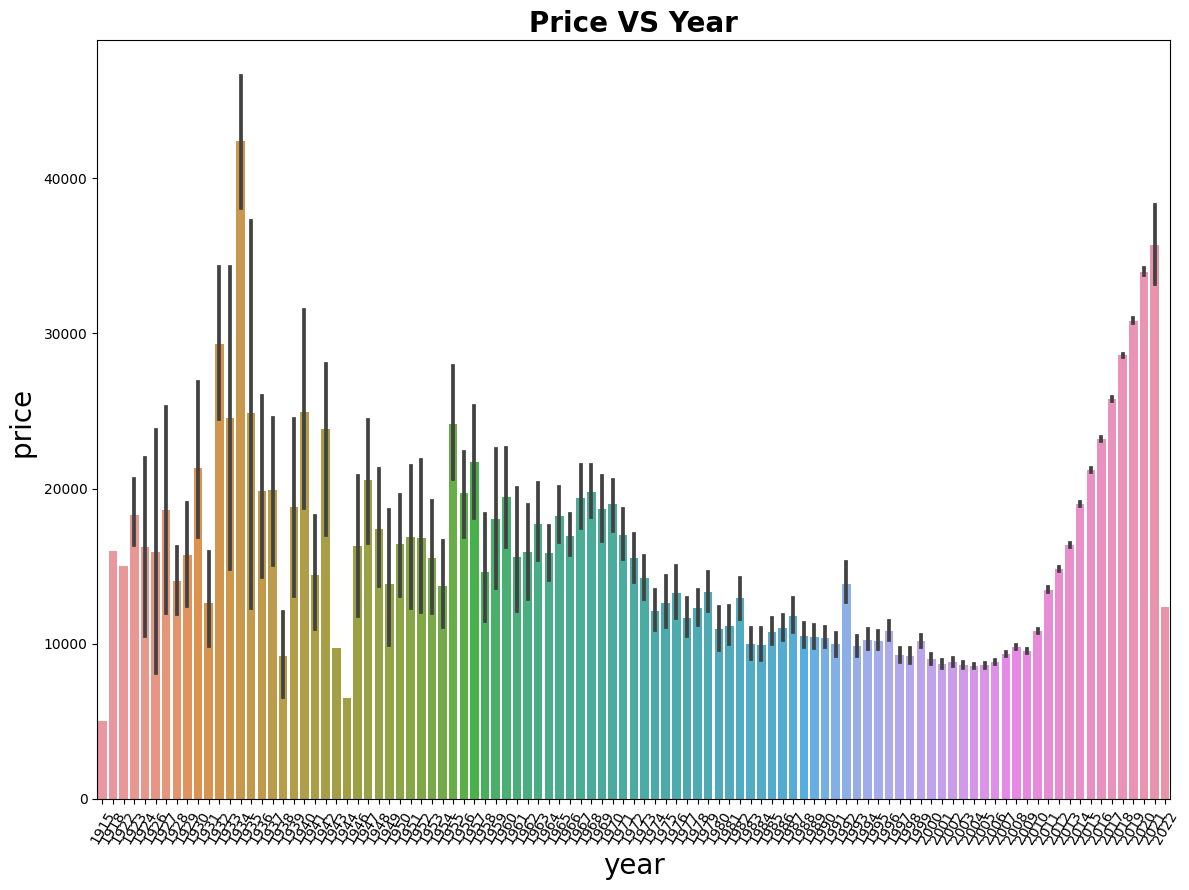

In [ ]:
plt.rcParams["figure.autolayout"] = True
sns.set_palette('summer_r')
plt.figure(figsize =(12,9))
sns.barplot(y=new_df['price'],x=new_df['year'])
plt.title("Price VS Year",fontsize=20,fontweight ='bold')
plt.xlabel('year',fontsize = 20)
plt.xticks(rotation=60)
plt.ylabel('price ',fontsize = 20)
plt.tight_layout()
plt.show()

In [ ]:
new_df = new_df[new_df['year'] > 1993]
new_df.shape


(258900, 16)

In [ ]:
new_df['year'].value_counts()

2018    23709
2017    23641
2013    21863
2014    20768
2015    20301
2016    19404
2012    17341
2011    14841
2019    13747
2008    11866
2010    11455
2007     9785
2009     8726
2006     7816
2020     7560
2005     6300
2004     5091
2003     3796
2002     2698
2001     2039
2000     1569
1999     1302
1998      788
1997      722
1995      603
1996      597
1994      441
2021      130
2022        1
Name: year, dtype: int64

In [ ]:
new_df['posting_date'] = pd.to_datetime(new_df['posting_date'], utc=True)
new_df['posting_year'] = new_df['posting_date'].dt.strftime('%Y')

new_df


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,posting_year
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,2021
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,2021
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,2021
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,2021
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03 19:02:03+00:00,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441796,others,33590,2018,lexus,others,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy,2021-04-04 09:21:34+00:00,2021
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,2021-04-04 09:21:31+00:00,2021
441798,others,30590,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,2021-04-04 09:21:29+00:00,2021
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,2021-04-04 09:21:11+00:00,2021


In [ ]:
new_df['posting_year'].value_counts()

2021    258489
2013        62
2014        52
2015        32
2011        29
2018        29
2010        28
2016        27
2017        26
2009        20
2019        18
2012        18
2007        15
2002        11
2022        10
2020         9
1996         5
2004         4
1995         4
2005         2
2003         2
2008         2
2006         2
1997         1
2032         1
1998         1
1992         1
Name: posting_year, dtype: int64

In [ ]:
new_df = new_df.loc[new_df['posting_year'] != '2032']

In [ ]:
new_df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,posting_year
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,2021
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,2021
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,2021
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,2021
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03 19:02:03+00:00,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441796,others,33590,2018,lexus,others,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy,2021-04-04 09:21:34+00:00,2021
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,2021-04-04 09:21:31+00:00,2021
441798,others,30590,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,2021-04-04 09:21:29+00:00,2021
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,2021-04-04 09:21:11+00:00,2021


In [ ]:
new_df['posting_year'].value_counts()

2021    258489
2013        62
2014        52
2015        32
2011        29
2018        29
2010        28
2016        27
2017        26
2009        20
2019        18
2012        18
2007        15
2002        11
2022        10
2020         9
1996         5
2004         4
1995         4
2003         2
2005         2
2008         2
2006         2
1997         1
1998         1
1992         1
Name: posting_year, dtype: int64

In [ ]:
new_df.dtypes

region                       object
price                         int64
year                          int64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
posting_year                 object
dtype: object

In [ ]:
new_df['posting_year'] = new_df['posting_year'].astype(int)


<ipython-input-57-dd5936292a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['posting_year'] = new_df['posting_year'].astype(int)


In [ ]:
new_df.dtypes

region                       object
price                         int64
year                          int64
manufacturer                 object
model                        object
condition                    object
cylinders                    object
fuel                         object
odometer                    float64
title_status                 object
transmission                 object
drive                        object
type                         object
paint_color                  object
state                        object
posting_date    datetime64[ns, UTC]
posting_year                  int64
dtype: object

In [ ]:
new_df['car_age'] = new_df['posting_year'] - new_df['year']
new_df

<ipython-input-59-4408ca9ead24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['car_age'] = new_df['posting_year'] - new_df['year']


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,posting_year,car_age
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923.0,clean,other,unknown,pickup,white,al,2021-05-04 17:31:18+00:00,2021,7
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,unknown,pickup,blue,al,2021-05-04 17:31:08+00:00,2021,11
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160.0,clean,other,unknown,pickup,red,al,2021-05-04 17:31:25+00:00,2021,1
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124.0,clean,other,unknown,pickup,red,al,2021-05-04 15:41:31+00:00,2021,4
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,2021-05-03 19:02:03+00:00,2021,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441796,others,33590,2018,lexus,others,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy,2021-04-04 09:21:34+00:00,2021,3
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,2021-04-04 09:21:31+00:00,2021,2
441798,others,30590,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,2021-04-04 09:21:29+00:00,2021,1
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,2021-04-04 09:21:11+00:00,2021,3


In [ ]:
new_df['car_age'].value_counts()

 3     23707
 4     23595
 8     21828
 7     20726
 6     20257
 5     19363
 9     17325
 10    14815
 2     13738
 13    11862
 11    11450
 14     9781
 12     8722
 15     7811
 1      7554
 16     6299
 17     5087
 18     3796
 19     2698
 20     2036
 21     1569
 22     1302
 23      781
 24      722
 26      603
 25      597
 27      441
 0       162
-4       119
-1        52
-2        44
-5        10
-3        10
-6         8
-7         4
-8         4
-9         4
-10        3
-11        3
-21        2
-24        2
-12        2
-14        2
-15        1
-17        1
-13        1
Name: car_age, dtype: int64

In [ ]:
new_df = new_df.loc[new_df['car_age'] >= 0]

In [ ]:
new_df['car_age'].value_counts()

3     23707
4     23595
8     21828
7     20726
6     20257
5     19363
9     17325
10    14815
2     13738
13    11862
11    11450
14     9781
12     8722
15     7811
1      7554
16     6299
17     5087
18     3796
19     2698
20     2036
21     1569
22     1302
23      781
24      722
26      603
25      597
27      441
0       162
Name: car_age, dtype: int64

In [ ]:
new_df.to_csv("final_car_sales.csv", index = False)

In [ ]:
new_df.drop(['posting_date'], axis = 1, inplace = True)
new_df.drop(['year'], axis = 1, inplace = True)
new_df.drop(['posting_year'], axis = 1, inplace = True)
new_df.describe()

<ipython-input-64-475fd224dd1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['posting_date'], axis = 1, inplace = True)
<ipython-input-64-475fd224dd1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['year'], axis = 1, inplace = True)
<ipython-input-64-475fd224dd1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['posting_year'], axis = 1, inplace = True)


,price,odometer,car_age
count,258627.000000,258627.000000,258627.000000
mean,18440.297262,93141.284243,8.384875
std,11529.679267,56790.048887,5.073075
min,3525.000000,7653.000000,0.000000
25%,8500.000000,42642.000000,4.000000
50%,15988.000000,89774.000000,8.000000
75%,26590.000000,133130.000000,11.000000
max,54988.000000,272412.000000,27.000000


Data Visualization

<ipython-input-65-a4ff67bfeb7b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr(), annot=True)


<Axes: >

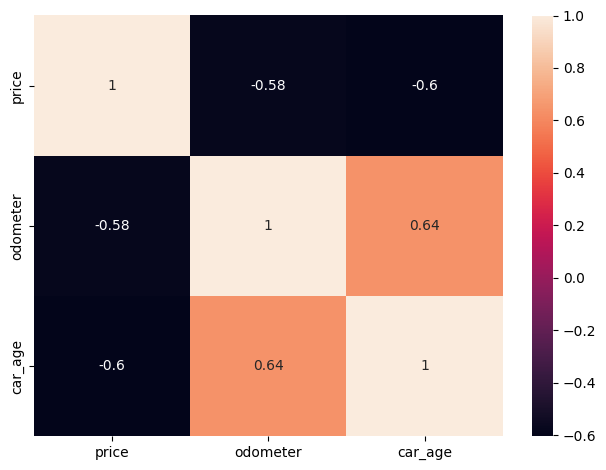

In [ ]:
sns.heatmap(new_df.corr(), annot=True)


In [ ]:
new_df.columns


Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'car_age'],
      dtype='object')

In [ ]:
training_df = new_df.copy()


In [ ]:
training_df.to_csv("training_df.csv", index = False)

Machine Learning Models

In [ ]:
import pandas as pd

training_df = pd.read_csv('/content/training_df.csv' )

In [ ]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
training_df = training_df.drop(['region', 'paint_color', 'title_status'], axis=1)
training_df.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,state,car_age
0,33590,gmc,others,good,8 cylinders,gas,57923.0,other,unknown,pickup,al,7
1,22590,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,other,unknown,pickup,al,11
2,39590,chevrolet,others,good,8 cylinders,gas,19160.0,other,unknown,pickup,al,1
3,30990,toyota,others,good,8 cylinders,gas,41124.0,other,unknown,pickup,al,4
4,15000,ford,others,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,al,8


In [ ]:
### BEGIN SOLUTION
numeric_dummies = pd.get_dummies(training_df)
numeric_dummies

,price,odometer,car_age,manufacturer_acura,manufacturer_audi,manufacturer_bmw,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,33590,57923.0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22590,71229.0,11,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,39590,19160.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30990,41124.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15000,128000.0,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258622,33590,30814.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258623,23590,32226.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258624,30590,12029.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258625,28990,30112.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:

columns = numeric_dummies.columns.tolist()
columns.remove('price')
columns

['odometer',
 'car_age',
 'manufacturer_acura',
 'manufacturer_audi',
 'manufacturer_bmw',
 'manufacturer_cadillac',
 'manufacturer_chevrolet',
 'manufacturer_chrysler',
 'manufacturer_dodge',
 'manufacturer_ford',
 'manufacturer_gmc',
 'manufacturer_honda',
 'manufacturer_hyundai',
 'manufacturer_jeep',
 'manufacturer_kia',
 'manufacturer_lexus',
 'manufacturer_mercedes-benz',
 'manufacturer_nissan',
 'manufacturer_others',
 'manufacturer_ram',
 'manufacturer_subaru',
 'manufacturer_toyota',
 'manufacturer_volkswagen',
 'model_1500',
 'model_2500',
 'model_3500',
 'model_accord',
 'model_altima',
 'model_camaro',
 'model_camry',
 'model_charger',
 'model_civic',
 'model_corolla',
 'model_corvette',
 'model_cr-v',
 'model_cruze',
 'model_edge',
 'model_elantra',
 'model_equinox',
 'model_escape',
 'model_explorer',
 'model_f-150',
 'model_f-250',
 'model_f-350',
 'model_f150',
 'model_focus',
 'model_forester',
 'model_fusion',
 'model_grand caravan',
 'model_grand cherokee',
 'model_i

In [ ]:
X = numeric_dummies[columns].values
y = numeric_dummies['price'].values.reshape(-1,1)
print(X.shape, y.shape)


(258627, 170) (258627, 1)


In [ ]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:

from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)


In [ ]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
# y_train_scaled = y_scaler.transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_squared_log_error

def result(y_test, predictions):
    r=[]
    r.append('%.4f' % r2_score(y_test,predictions))
    r.append('%.4f' % (r2_score(y_test,predictions)*100))
    r.append('%.2f' % mean_squared_error(y_test, predictions))
    r.append('%.2f' % mean_absolute_error(y_test, predictions))
    r.append('%.2f' % np.sqrt(mean_squared_error(y_test, predictions)))
    
    return (r)

#dataframe that store the performance of each model
score_data = pd.DataFrame(index=['R2 Score', 'Accuracy(%)', 'Mean Squared Error', 'Mean Absolute Error', 'Root MSE'])

In [ ]:
# Create a LinearRegression model and fit it to the scaled training data
import warnings
warnings.filterwarnings('ignore')
### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
### END SOLUTION

In [ ]:
# Calculating and recording model peformance
# R2_score = r2_score(y_test, predictions)*100
score_linear = result(y_test, predictions)
score_data['Linear Regression'] = score_linear
print('R2_score: ', score_linear[0])
print('Mean squared error: ', score_linear[2])
print('Mean absolute error: ', score_linear[3])
print('Root mean squared error: ', score_linear[4])

R2_score:  0.7415
Mean squared error:  34386178.79
Mean absolute error:  4388.14
Root mean squared error:  5863.97


In [ ]:
 # LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train)

predictions = lasso.predict(X_test_scaled)     

In [ ]:
# Calculating and recording model peformance
score_lasso = result(y_test, predictions)
score_data['Lasso Regression'] = score_lasso
print('R2_score: ', score_lasso[0])
print('Mean squared error: ', score_lasso[2])
print('Mean absolute error: ', score_lasso[3])
print('Root mean squared error: ', score_lasso[4])

R2_score:  0.7416
Mean squared error:  34373140.38
Mean absolute error:  4384.66
Root mean squared error:  5862.86


In [ ]:

 # Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train)

predictions = ridge.predict(X_test_scaled)

In [ ]:
# Calculating and recording model peformance
score_ridge = result(y_test, predictions)
score_data['Ridge Regression'] = score_ridge
print('R2_score: ', score_ridge[0])
print('Mean squared error: ', score_ridge[2])
print('Mean absolute error: ', score_ridge[3])
print('Root mean squared error: ', score_ridge[4])

R2_score:  0.7416
Mean squared error:  34373150.41
Mean absolute error:  4384.66
Root mean squared error:  5862.86


In [ ]:
 # ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train)

predictions = elasticnet.predict(X_test_scaled)

In [ ]:
# Calculating and recording model peformance
score_elasticnet = result(y_test, predictions)
score_data['Elastic Net Regression'] = score_elasticnet
print('R2_score: ', score_elasticnet[0])
print('Mean squared error: ', score_elasticnet[2])
print('Mean absolute error: ', score_elasticnet[3])
print('Root mean squared error: ', score_elasticnet[4])

R2_score:  0.7416
Mean squared error:  34375416.18
Mean absolute error:  4384.04
Root mean squared error:  5863.06


In [ ]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf_model = RandomForestRegressor(n_estimators=150,random_state=0, min_samples_leaf=1, max_features=0.3, n_jobs=-1, oob_score=True)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
score_rfr = result(y_test, predictions)
score_data['Random Forest Regression'] = score_rfr
print('R2 score: ', score_rfr[0])
print('Mean squared error: ', score_rfr[2])
print('Mean absolute error: ', score_rfr[3])
print('Root mean squared error: ', score_rfr[4])

R2 score:  0.9289
Mean squared error:  9455064.14
Mean absolute error:  1611.30
Root mean squared error:  3074.91


In [ ]:
# Decision Tree Model
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

# Create the decision tree regressor instance
model = tree.DecisionTreeRegressor()

# Fit the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [ ]:
score_decision = result(y_test, predictions)
score_data['Decision Tree Regression'] = score_decision
print('R2 score: ', score_decision[0])
print('Mean squared error: ', score_decision[2])
print('Mean absolute error: ', score_decision[3])
print('Root mean squared error: ', score_decision[4])

R2 score:  0.8643
Mean squared error:  18049379.44
Mean absolute error:  1916.19
Root mean squared error:  4248.46


In [ ]:
score_data

,Linear Regression,Lasso Regression,Ridge Regression,Elastic Net Regression,Random Forest Regression,Decision Tree Regression
R2 Score,0.7415,0.7416,0.7416,0.7416,0.9289,0.8643
Accuracy(%),74.1544,74.1642,74.1642,74.1625,92.8933,86.4336
Mean Squared Error,34386178.79,34373140.38,34373150.41,34375416.18,9455064.14,18049379.44
Mean Absolute Error,4388.14,4384.66,4384.66,4384.04,1611.30,1916.19
Root MSE,5863.97,5862.86,5862.86,5863.06,3074.91,4248.46


In [ ]:
score_data.to_csv('Model_peformance.csv')